In [1728]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt


import statsmodels.api as sm
from statsmodels.tsa.filters.filtertools import convolution_filter
import statsmodels.graphics.tsaplots as tsplots
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.forecasting.stl import STLForecast
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.arima.model import ARIMA
from sklearn.linear_model import LinearRegression
import pickle

# Load temperature data and define target city/country and time window for history and future

In [1729]:
temperatureall = pd.read_csv('data/GlobalLandTemperaturesByCity.csv')
country = 'United States'
city = 'Austin'
history_start = '2000-01-01'
history_end = '2010-01-01'
future_start = '2010-01-01'
future_end = '2013-01-01'

temperature = temperatureall[(temperatureall['Country'] == country) & (temperatureall['City'] == city)].copy().dropna(subset=['AverageTemperature'])
temperature = temperature[['dt', 'AverageTemperature']]
temperature.head()

FileNotFoundError: [Errno 2] No such file or directory: 'data/GlobalLandTemperaturesByCity.csv'

# center indexes and select the right time window
# fill missing data

In [ ]:
temperature = temperature.set_index(pd.to_datetime(temperature['dt'])).drop(columns=['dt'])
temperature = temperature[temperature.index >= history_start]

date_range = pd.date_range(start=history_start, end=future_end, freq='MS')
temperature = temperature.reindex(date_range)

temperature.head()


,AverageTemperature
2000-01-01,12.973
2000-02-01,16.413
2000-03-01,19.150
2000-04-01,20.549
2000-05-01,25.811


Plot the 'source' data

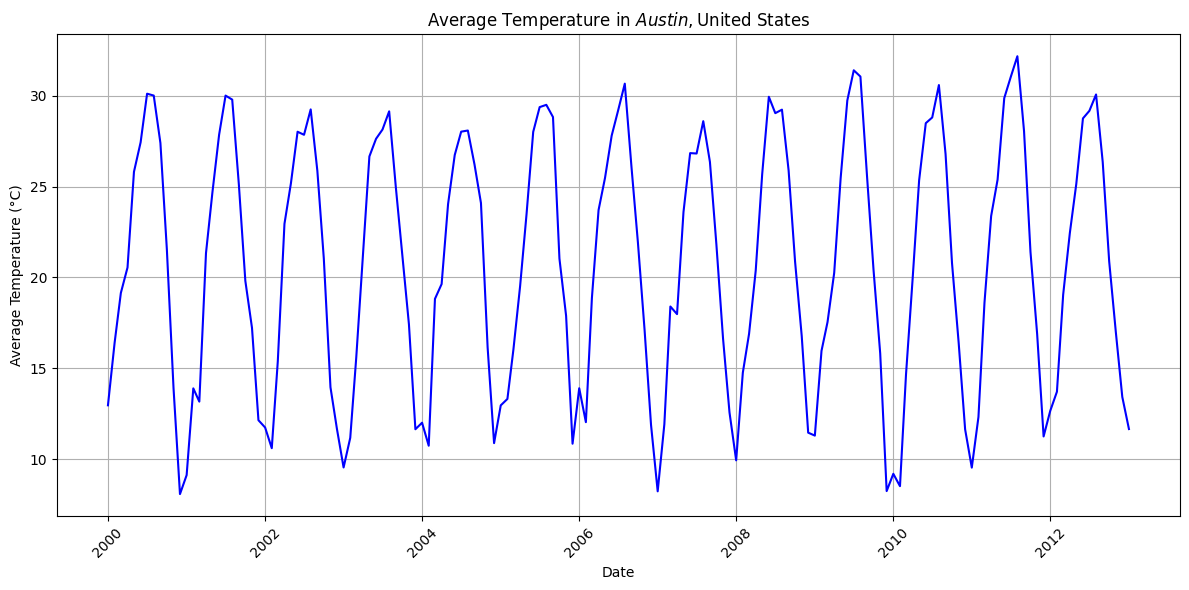

In [ ]:

plt.figure(figsize=(12, 6))
plt.plot(temperature['AverageTemperature'], color='blue', linestyle='-')
plt.title(f'Average Temperature in ${city}, ${country}')
plt.xlabel('Date')
plt.ylabel('Average Temperature (°C)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()  # Adjusts the plot to ensure everything fits without overlapping
plt.savefig(f'images/avetemp_{city}_{country}.png')
plt.show()


# split the data to history and future

In [ ]:
y_hist = temperature.loc[history_start : history_end, 'AverageTemperature']
y_future = temperature.loc[future_start : future_end, 'AverageTemperature']
print(y_hist)

2000-01-01    12.973
2000-02-01    16.413
2000-03-01    19.150
2000-04-01    20.549
2000-05-01    25.811
               ...  
2009-09-01    25.519
2009-10-01    20.414
2009-11-01    15.827
2009-12-01     8.256
2010-01-01     9.206
Freq: MS, Name: AverageTemperature, Length: 121, dtype: float64


# plot history and future

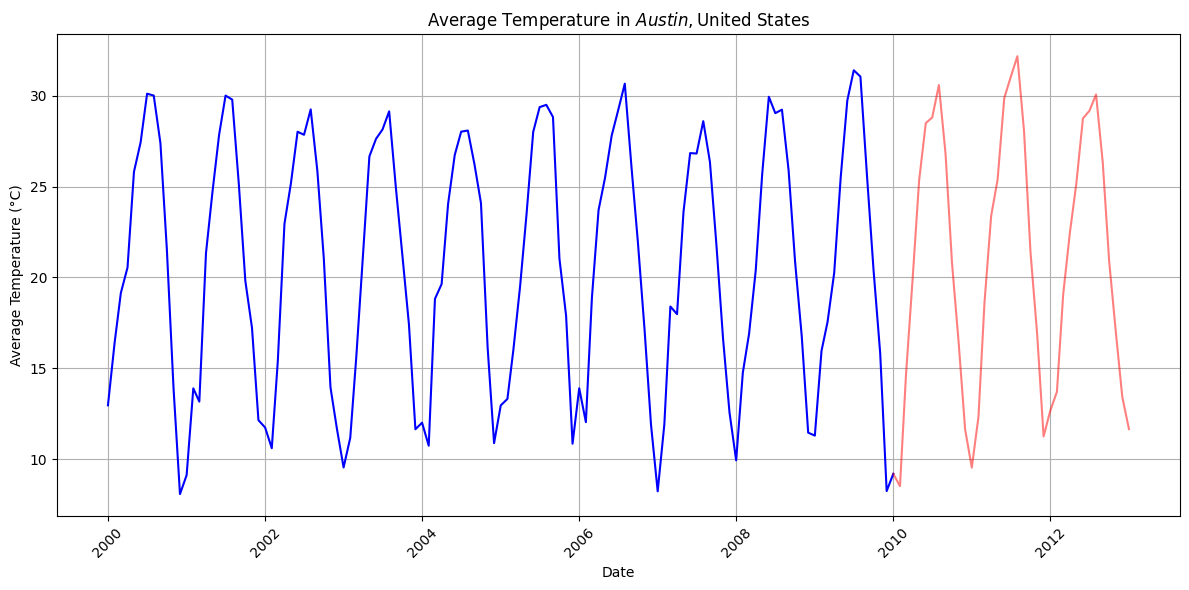

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(y_hist, color='blue')
plt.plot(y_future, alpha=0.5, color='red')
plt.title(f'Average Temperature in ${city}, ${country}')
plt.xlabel('Date')
plt.ylabel('Average Temperature (°C)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()  # Adjusts the plot to ensure everything fits without overlapping
plt.savefig(f'images/avetemp_h_f_{city}_{country}.png')
plt.show()

In [ ]:
# function to extrapolate data at bith ends

In [ ]:
def _extrapolate_trend(trend, npoints):
    """
    Replace nan values on trend's end-points with least-squares extrapolated
    values with regression considering npoints closest defined points.
    """
    front = next(i for i, vals in enumerate(trend)
                 if not np.any(np.isnan(vals)))
    back = trend.shape[0] - 1 - next(i for i, vals in enumerate(trend[::-1])
                                     if not np.any(np.isnan(vals)))
    front_last = min(front + npoints, back)
    back_first = max(front, back - npoints)

    k, n = np.linalg.lstsq(
        np.c_[np.arange(front, front_last), np.ones(front_last - front)],
        trend[front:front_last], rcond=-1)[0]
    extra = (np.arange(0, front) * np.c_[k] + np.c_[n]).T
    if trend.ndim == 1:
        extra = extra.squeeze()
    trend[:front] = extra

    k, n = np.linalg.lstsq(
        np.c_[np.arange(back_first, back), np.ones(back - back_first)],
        trend[back_first:back], rcond=-1)[0]
    extra = (np.arange(back + 1, trend.shape[0]) * np.c_[k] + np.c_[n]).T
    if trend.ndim == 1:
        extra = extra.squeeze()
    trend[back + 1:] = extra

    return trend

# utility function to generate array of yearly (period = 12 months) start dates


In [ ]:
def generate_yearly_dates(history_start, history_end):
    """
    Generate DateTimeIndex with the beginning of each year from history_start to history_end.

    Parameters:
    history_start (datetime): The starting datetime.
    history_end (datetime): The ending datetime.

    Returns:
    pd.DatetimeIndex: DateTimeIndex with the beginning of each year between the start and end dates.
    """
    # Ensure history_start and history_end are in datetime format
    history_start = pd.to_datetime(history_start)
    history_end = pd.to_datetime(history_end)

    # Generate yearly dates from history_start to history_end
    yearly_dates = pd.date_range(start=history_start, end=history_end, freq='YS')

    return yearly_dates

# utility function to convert yearly start dates to array of indexes in the actual dataframe

In [ ]:
def convert_to_index(dataframe, datetime_indexes):
    """
    Convert a series of datetime indexes to their corresponding index positions in a DataFrame.

    Parameters:
    dataframe (pd.DataFrame): DataFrame with a datetime index.
    datetime_indexes (pd.DatetimeIndex): DatetimeIndex to be converted to index positions.

    Returns:
    list: A list of index positions in the DataFrame corresponding to the datetime indexes.
    """
    # Convert the DateTimeIndex to a list of index positions in the DataFrame
    index_positions = [dataframe.index.get_loc(dt) for dt in datetime_indexes if dt in dataframe.index]

    return index_positions

# utility function to find indexes of yearly low values and print it

In [ ]:
def find_yearly_low_values(y_hist):
    # Group the data by year and find the index of the minimum value for each year
    yearly_lows = y_hist.resample('Y').min()

    # Retrieve the rows corresponding to the yearly lows
    yearly_low_dates = y_hist[y_hist.isin(yearly_lows)].dropna().index

    # Create a DataFrame from the results
    yearly_low_values_df = pd.DataFrame({
        'dt': yearly_low_dates,
        'AverageTemperature': yearly_lows.values
    })

    return yearly_low_values_df

In [ ]:
yearly_dates = generate_yearly_dates(history_start, history_end)
yearly_dates

DatetimeIndex(['2000-01-01', '2001-01-01', '2002-01-01', '2003-01-01',
               '2004-01-01', '2005-01-01', '2006-01-01', '2007-01-01',
               '2008-01-01', '2009-01-01', '2010-01-01'],
              dtype='datetime64[ns]', freq='AS-JAN')

In [ ]:
yearly_indexes = convert_to_index(temperature, yearly_dates)
yearly_indexes

[0, 12, 24, 36, 48, 60, 72, 84, 96, 108, 120]

In [ ]:
period = int(np.round(np.mean(np.diff(yearly_indexes))))
period

12

In [ ]:
num_seasons = len(yearly_indexes) - 1
num_seasons

10

# calculate trend

In [ ]:
filt = np.array([.5] + [1] * (period - 1) + [.5]) / period

nsides = 2
trend = convolution_filter(y_hist, filt, nsides)
trend = _extrapolate_trend(trend, period + 1)

# plot the trend

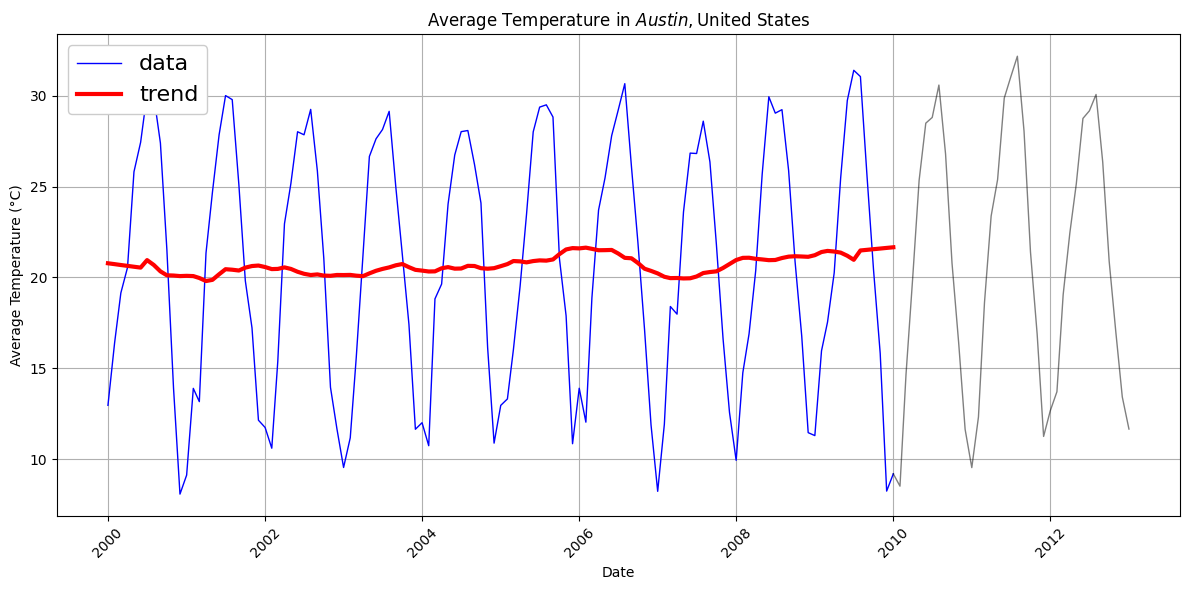

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(y_hist, color='blue',label='data',linewidth=1)
plt.plot(trend,label='trend',color='red',linewidth=3)
plt.plot(y_future,'k',alpha=0.5,linewidth=1)
plt.title(f'Average Temperature in ${city}, ${country}')
plt.xlabel('Date')
plt.ylabel('Average Temperature (°C)')
plt.grid(True)
plt.legend(loc='upper left',fontsize=16,framealpha=1)
plt.xticks(rotation=45)
plt.tight_layout()  # Adjusts the plot to ensure everything fits without overlapping
plt.savefig(f'images/avetemp_trend_{city}_{country}.png')
plt.show()


# calculate and plot detrended

In [ ]:
detrended = y_hist - trend
detrended = detrended.to_numpy()

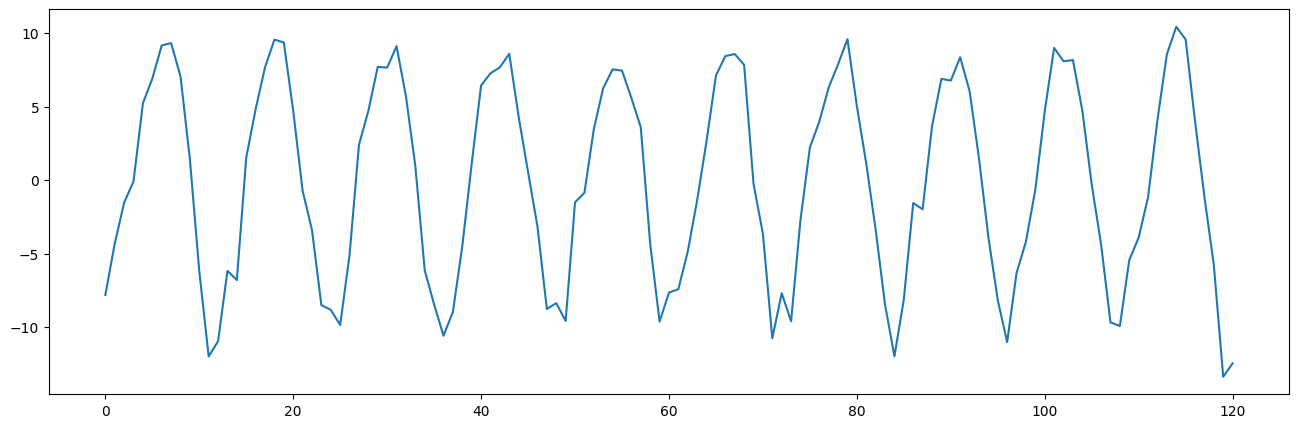

In [ ]:
plt.figure(figsize=(16, 5))
plt.plot(detrended)
plt.savefig(f'images/avetemp_deterred_{city}_{country}.png')

# plot seasons (years in this case) of the historical data 

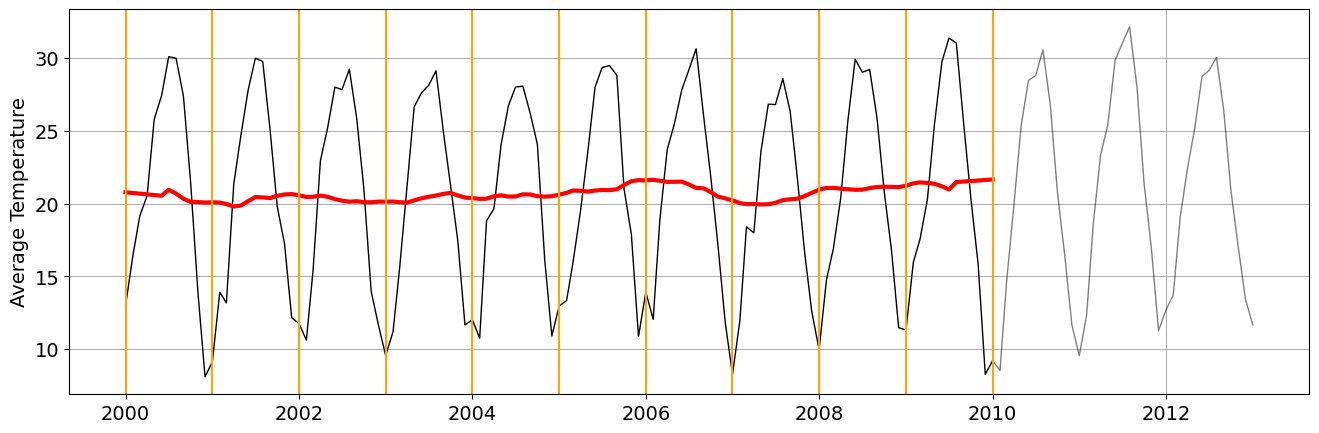

In [ ]:
plt.figure(figsize=(16,5))
plt.plot(y_hist,'k',label='data',linewidth=1)
plt.plot(y_future,'k',alpha=0.5,linewidth=1)
plt.plot(trend,label='trend',color='red',linewidth=3)
for date in yearly_dates:
    plt.axvline(x=pd.to_datetime(date),color='orange')
plt.grid()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Average Temperature',fontsize=14)
plt.savefig(f'images/avetemp_seasons_{city}_{country}.png')

In [ ]:
# define seasons lenth in terms of data points = 12
# calculate num_seasons using the length of yearly_indexes array

In [ ]:
y_hist.to_numpy()

array([12.973, 16.413, 19.15 , 20.549, 25.811, 27.435, 30.105, 30.003,
       27.393, 21.545, 13.917,  8.091,  9.135, 13.904, 13.175, 21.34 ,
       24.689, 27.847, 30.002, 29.78 , 25.093, 19.816, 17.228, 12.153,
       11.753, 10.614, 15.392, 22.951, 25.176, 28.014, 27.846, 29.243,
       25.865, 21.05 , 13.965, 11.681,  9.554, 11.185, 15.614, 21.186,
       26.656, 27.626, 28.135, 29.136, 24.968, 21.283, 17.421, 11.656,
       12.016, 10.752, 18.825, 19.639, 24.037, 26.734, 28.019, 28.081,
       26.211, 24.094, 16.149, 10.893, 12.969, 13.323, 16.046, 19.516,
       23.483, 28.007, 29.368, 29.494, 28.822, 21.04 , 17.893, 10.861,
       13.91 , 12.046, 18.873, 23.709, 25.475, 27.801, 29.186, 30.657,
       26.091, 21.927, 17.12 , 11.898,  8.243, 11.93 , 18.405, 17.986,
       23.599, 26.839, 26.817, 28.596, 26.353, 21.826, 16.643, 12.581,
        9.947, 14.765, 16.902, 20.383, 25.671, 29.937, 29.036, 29.228,
       25.883, 20.879, 16.777, 11.469, 11.307, 15.968, 17.55 , 20.255,
      

In [ ]:
print(detrended.shape)

(121,)


In [ ]:
num_seasons

10

In [ ]:
period

12

# calculate and plot mean_seasonals for 12 months starting from 0 index

period: 12
num_seasons: 10
seasonals shape: (12, 10)
yearly_indexes: [0, 12, 24, 36, 48, 60, 72, 84, 96, 108, 120]
detrended length: 121
2
4
6


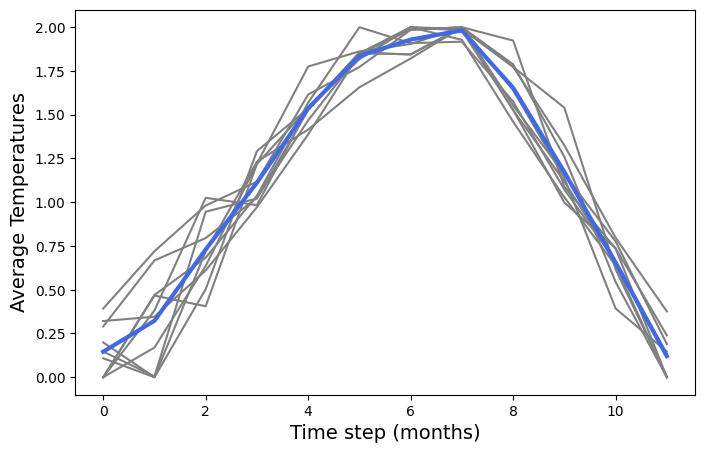

In [ ]:
seasonals = np.empty((period, num_seasons))

print("period:", period)
print("num_seasons:", num_seasons)
print("seasonals shape:", seasonals.shape)
print("yearly_indexes:", yearly_indexes)
print("detrended length:", len(detrended))

for p in range(num_seasons):
    s = detrended[yearly_indexes[p]:yearly_indexes[p]+period]
    s = 2 * (s - np.min(s)) / (np.max(s) - np.min(s))
    if s[1] < 0.1:
        print(p)
    seasonals[:, p] = s

mean_seasonals = seasonals.mean(axis=1)
    
plt.figure(figsize=(8,5))
for p in range(num_seasons):
    plt.plot(seasonals[:,p],color=0.5*np.ones(3))
plt.plot(mean_seasonals,color='royalblue',linewidth=3,label='mean seasonal')
plt.xlabel('Time step (months)',fontsize=14)
plt.xlabel('Time step (months)',fontsize=14)
plt.ylabel('Average Temperatures',fontsize=14)
plt.savefig('images/mean_seasonals.png')
plt.savefig(f'images/avetemp_mean_seasonals_{city}_{country}.png')
plt.show()

# checking if smoothening has any postive impact. I used savgol_filter

In [ ]:
import matplotlib.colors as mcolors
def generate_random_colors(num_colors):
    """
    Generate a list of random colors.

    Parameters:
    num_colors (int): The number of random colors to generate.

    Returns:
    list: A list of random color codes in HEX.
    """
    colors = np.random.rand(num_colors, 3)
    hex_colors = [mcolors.rgb2hex(color) for color in colors]

    return hex_colors

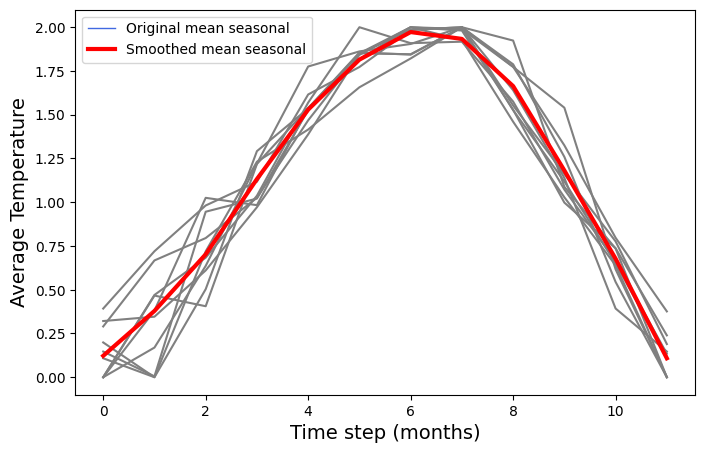

In [ ]:
from scipy.signal import savgol_filter
# Assuming mean_seasonals is the array you want to smoothen
window_size = 5  # Window size for Savitzky-Golay filter, must be odd
poly_order = 2  # Polynomial order to fit within the window

mean_seasonals = savgol_filter(mean_seasonals, window_size, poly_order)

season_colors = ['blue', 'green', 'orange', 'yellow', 'cyan', 'pink', '']

# Plot the original and smoothed curves
plt.figure(figsize=(8, 5))
for p in range(num_seasons):
    plt.plot(seasonals[:,p],color=0.5*np.ones(3))
#    plt.plot(seasonals[:,p],color=random_colors[p])
plt.plot(mean_seasonals, color='royalblue', linewidth=1, label='Original mean seasonal')
plt.plot(mean_seasonals, color='red', linewidth=3, label='Smoothed mean seasonal')
plt.xlabel('Time step (months)', fontsize=14)
plt.ylabel('Average Temperature', fontsize=14)
plt.legend()
plt.savefig('images/smoothen_mean_seasonals.png')
plt.savefig(f'images/avetemp_smoothed_mean_seasonals_{city}_{country}.png')
plt.show()

# remove outliers if any

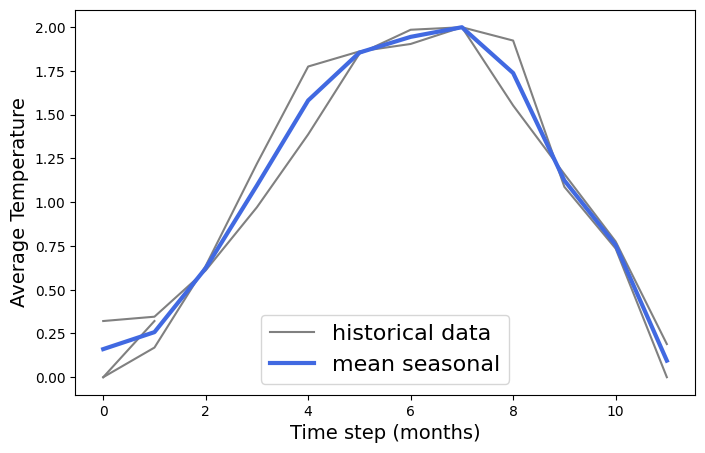

In [ ]:
#weird months 2, 4, 6, 10
seasonals = seasonals[:,[3, 5]]

mean_seasonals = seasonals.mean(axis=1)

plt.figure(figsize=(8,5))
plt.plot(seasonals[0],color=0.5*np.ones(3),label='historical data')
plt.plot(seasonals,color=0.5*np.ones(3))
plt.plot(mean_seasonals,color='royalblue',linewidth=3,label='mean seasonal')
plt.xlabel('Time step (months)',fontsize=14)
plt.xlabel('Time step (months)',fontsize=14)
plt.ylabel('Average Temperature',fontsize=14)
plt.legend(fontsize=16)
plt.show()

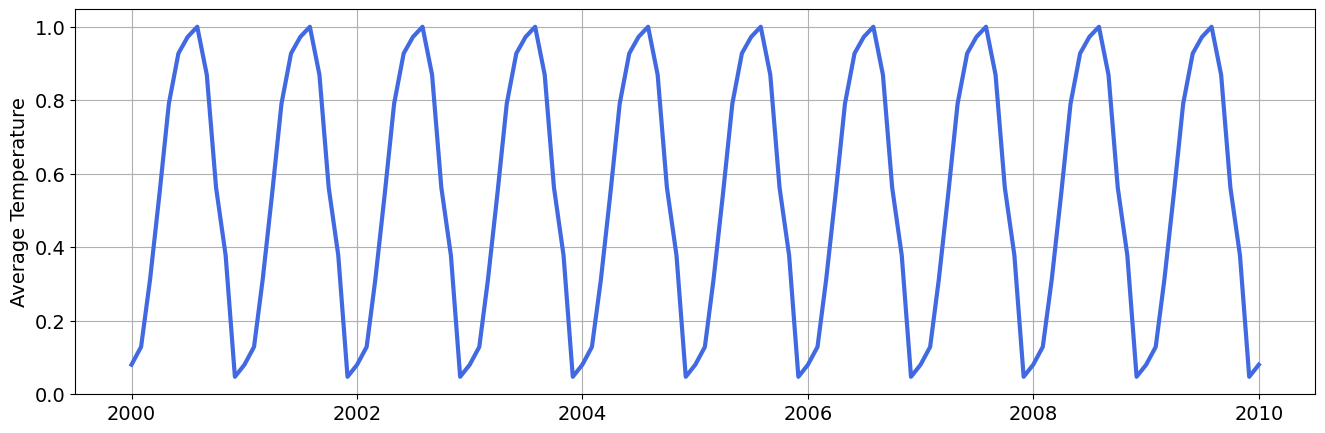

In [ ]:
seasonal = pd.Series(index=y_hist.index,data=0)

for low in yearly_indexes:
    if low+period<len(seasonal):
        seasonal[low:low+period] = mean_seasonals
    else:
        seasonal[low:] = mean_seasonals[:len(seasonal)-(low+period)]
        
        
seasonal = seasonal / np.max(seasonal)
    
plt.figure(figsize=(16,5))
plt.plot(seasonal,label='trend+seasonal',color='royalblue',linewidth=3)
plt.grid()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Average Temperature',fontsize=14)
plt.savefig('images/seasonal.png')

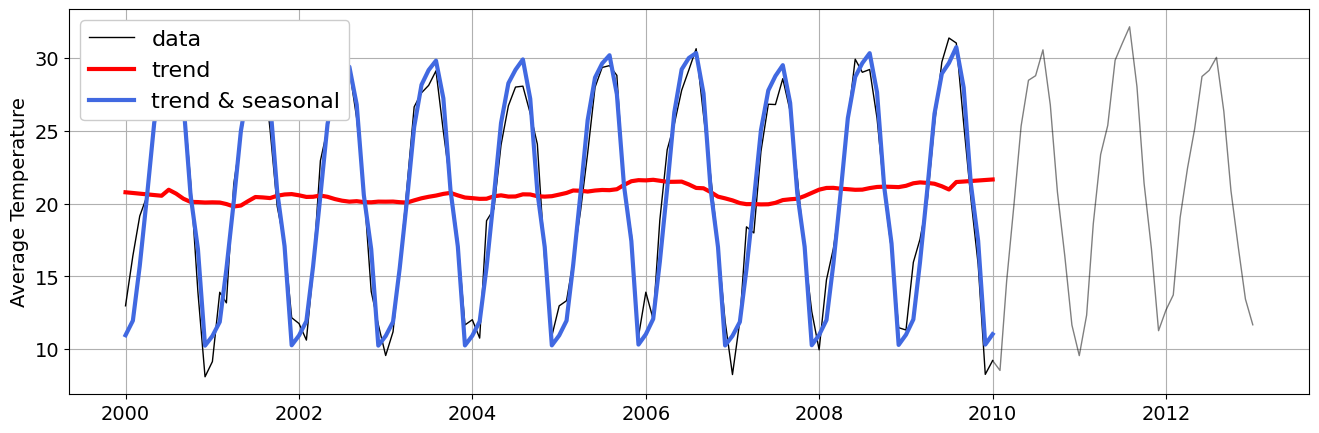

In [ ]:
offset = y_hist.mean() - (trend * seasonal).mean()
season_and_trend = (trend*seasonal) + offset
plt.figure(figsize=(16,5))
plt.plot(y_hist,'k',label='data',linewidth=1)
plt.plot(trend,label='trend',color='red',linewidth=3)
plt.plot(season_and_trend,label='trend & seasonal',color='royalblue',linewidth=3)
plt.plot(y_future,'k',alpha=0.5,linewidth=1)
plt.grid()
plt.legend(loc='upper left',fontsize=16,framealpha=1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Average Temperature',fontsize=14)
plt.savefig('images/season_and_trend.png')
plt.show()

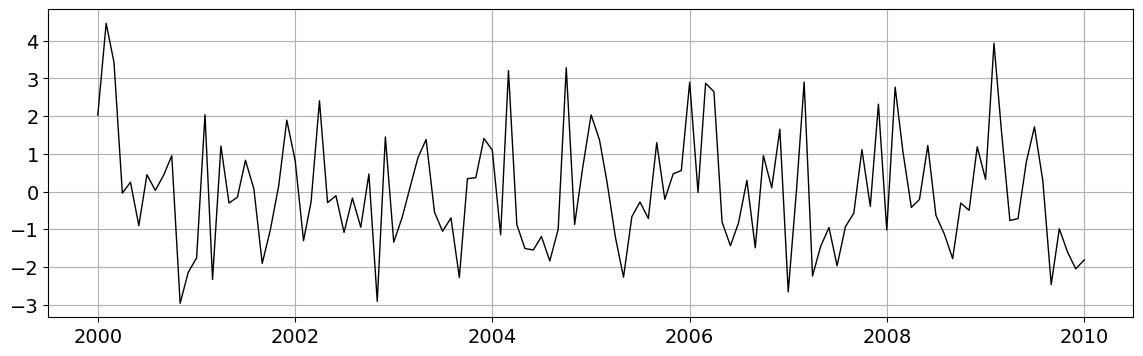

In [ ]:

residue = y_hist - season_and_trend
plt.figure(figsize=(14,4))
plt.plot(residue,'k',linewidth=1,label='model residue')
plt.grid()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

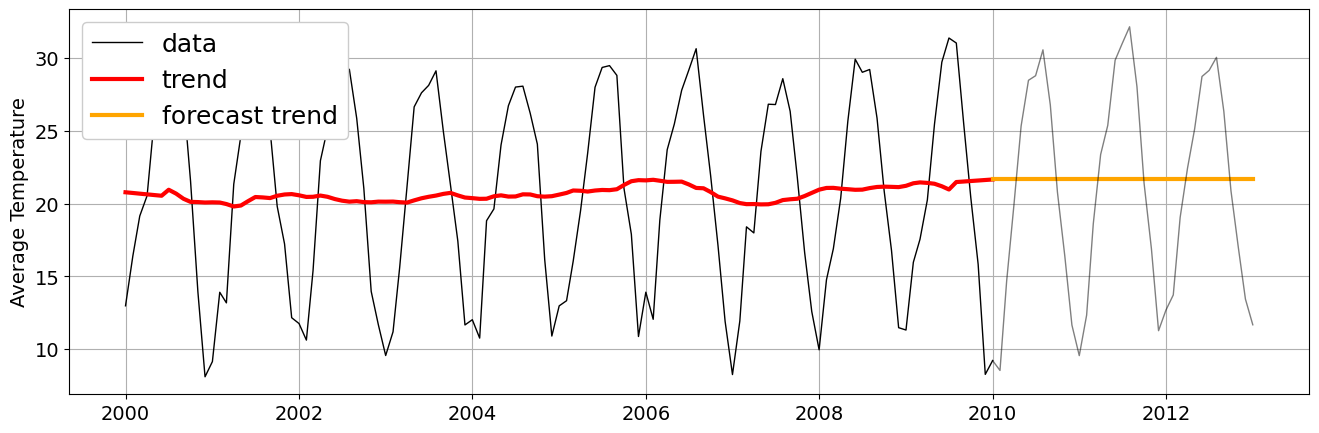

In [ ]:
h = len(y_hist)
f = len(y_future)
f_periods = int(1 + f/period)
yhat_trend = pd.Series(index=y_future.index, data=trend[-1])

plt.figure(figsize=(16,5))
plt.plot(y_hist,'k',label='data',linewidth=1)
plt.plot(trend,label='trend',color='red',linewidth=3)
plt.plot(yhat_trend,label='forecast trend',color='orange',linewidth=3)
plt.plot(y_future,'k',alpha=0.5,linewidth=1)
plt.grid()
plt.legend(loc='upper left',fontsize=18,framealpha=1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Average Temperature',fontsize=14)
plt.show()

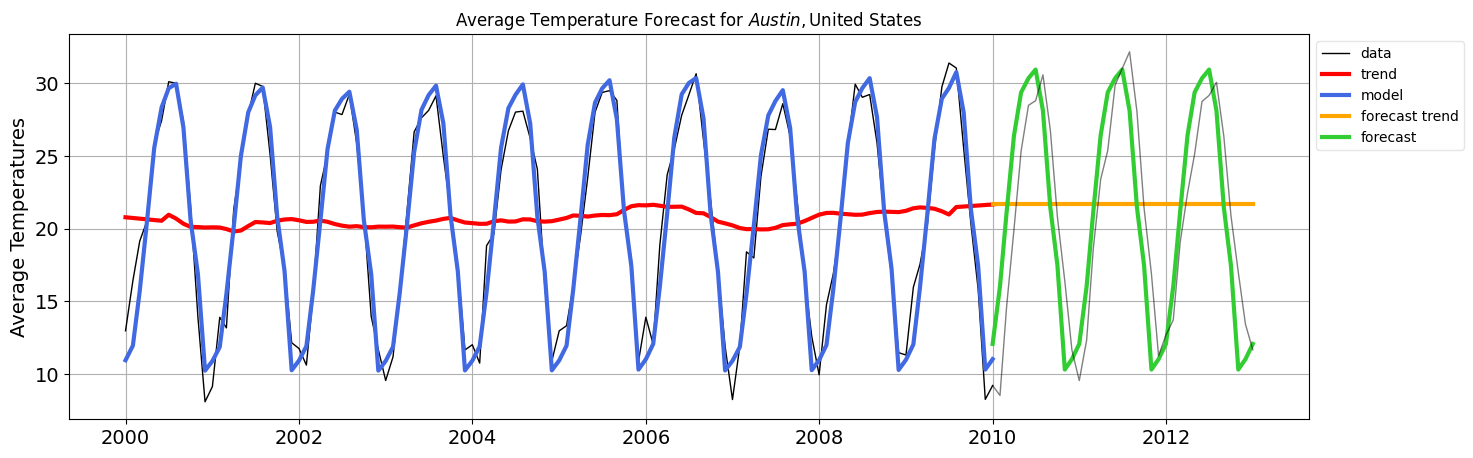

In [1730]:
offset = y_hist.mean() - (trend * seasonal).mean()
season_and_trend = (trend*seasonal) + offset
yhat_seasonal = pd.Series(index=y_future.index, dtype='float64')
for i in range(len(yhat_seasonal)):
    yhat_seasonal[i] = seasonal[-(f_periods*len(mean_seasonals)-i)]
yhat = (yhat_trend*yhat_seasonal) + offset

plt.figure(figsize=(16,5))
plt.title(f'Average Temperature Forecast for ${city}, ${country}')
plt.plot(y_hist,'k',label='data',linewidth=1)
plt.plot(trend,label='trend',color='red',linewidth=3)
plt.plot(season_and_trend,label='model',color='royalblue',linewidth=3)
plt.plot(yhat_trend,label='forecast trend',color='orange',linewidth=3)
plt.plot(yhat,label='forecast',color='limegreen',linewidth=3)
plt.plot(y_future,'k',alpha=0.5,linewidth=1)
plt.grid()
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize='medium', framealpha=0.5)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Average Temperatures',fontsize=14)
plt.savefig(f'images/avetemp_forecast_for_{city}_{country}.png')
plt.show()

In [ ]:
pred_error = y_future - yhat

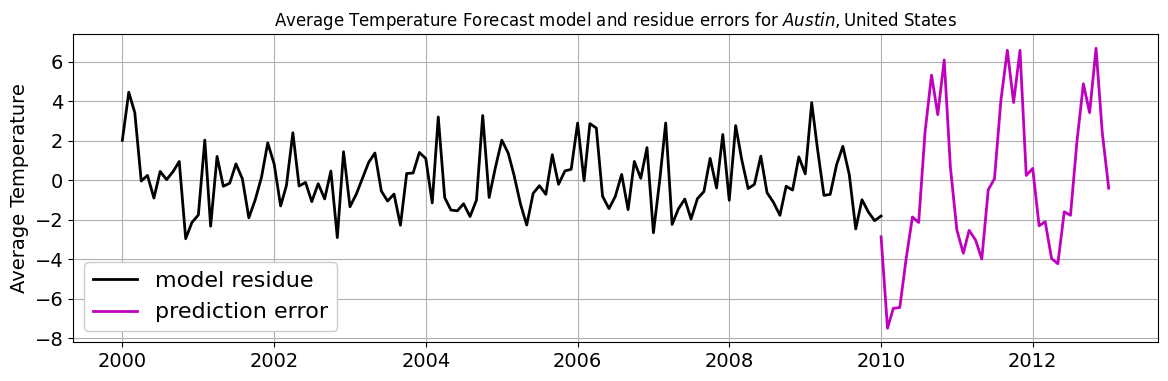

In [1731]:
plt.figure(figsize=(14,4))
plt.title(f'Average Temperature Forecast model and residue errors for ${city}, ${country}')
plt.plot(residue,'k',linewidth=2,label='model residue')
plt.plot(pred_error,'m',linewidth=2,label='prediction error')
plt.grid()
plt.legend(fontsize=16,framealpha=1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Average Temperature',fontsize=14)
plt.savefig(f'images/avetemp_forecast_residue_and_model_errors_for_{city}_{country}.png')
plt.show()

In [ ]:
MAEm = np.abs(residue).mean()
RMSEm = np.sqrt( np.square(residue).mean() )
MAEm, RMSEm

(1.2346076289301258, 1.543795319066125)

In [ ]:
MAEp = np.abs(pred_error).mean()
RMSEp = np.sqrt( np.square(pred_error).mean() )
MAEp, RMSEp

(3.3331296020150707, 3.9115889851013717)

In [ ]:
with open('decomp_temperature.pkl', 'wb') as file:
    pickle.dump( {'history': pd.DataFrame({'y_hist':y_hist,'t_and_s':season_and_trend,'ts_residue':residue}),
                  'future' : pd.DataFrame({'y_future':y_future,'yhat':yhat,'error':pred_error})} , file)